<a href="https://colab.research.google.com/github/CHENHUI-X/LSTM_encoder_decoder/blob/master/Time_series_predict_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import pandas as pd

def synthetic_data(Nt = 2000, tf = 80 * np.pi):
    
    '''
    create synthetic time series dataset
    : param Nt:       number of time steps 
    : param tf:       final time
    : return t, y:    time, feature arrays
    '''
    
    t = np.linspace(0., tf, Nt)
    y = np.sin(2. * t) + 0.5 * np.cos(t) + np.random.normal(0., 0.2, Nt)

    return t, y



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# looks like normalizing input values curtial for the model
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()

In [ ]:
def get_data():
    df2 = pd.read_excel('/content/df2-weekday-CHEN.xlsx',sheet_name = 1)
    time        = df2['index']    
    amount   = df2['total_amount'].values
    # amount_scaler = scaler.fit_transform(amount.reshape(-1, 1)).reshape(-1)
    amount_scaler = df2['amount'].values
    # return time, amount_scaler
    t = np.array(range(len(time)))
    return t , amount_scaler

In [ ]:

def train_test_split(t, y, split = 0.8):

  '''
  
  split time series into train/test sets
  
  : param t:                      time array
  : para y:                       feature array
  : para split:                   percent of data to include in training set 
  : return t_train, y_train:      time/feature training and test sets;  
  :        t_test, y_test:        (shape: [# samples, 1])
  
  '''
  
  indx_split = int(split * len(y))
  indx_train = np.arange(0, indx_split)
  indx_test = np.arange(indx_split, len(y))
  
  t_train = t[indx_train]
  y_train = y[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_test = t[indx_test]
  y_test = y[indx_test]
  y_test = y_test.reshape(-1, 1)
  
  return t_train, y_train, t_test, y_test 


In [ ]:

def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
  
    '''
    create a windowed dataset
    
    : param y:                time series feature (array)
    : param input_window:     number of y samples to give model 
    : param output_window:    number of future y samples to predict  
    : param stide:            spacing between windows   
    : param num_features:     number of features (i.e., 1 for us, but we could have multiple features)
    : return X, Y:            arrays with correct dimensions for LSTM
    :                         (i.e., [input/output window size # examples, # features])
    '''
  
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1 # 就是有多少个窗口

    X = np.zeros([input_window, num_samples, num_features]) # 这么放是因为可以加快速度:(seq,batch,feature)
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]
            # ,这里是真10->1,而不是10->10,然后最后一个是实际预测值

    return X, Y



In [ ]:

def numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest):
    '''
    convert numpy array to PyTorch tensor
    
    : param Xtrain:                           windowed training input data (input window size, # examples, # features); np.array
    : param Ytrain:                           windowed training target data (output window size, # examples, # features); np.array
    : param Xtest:                            windowed test input data (input window size, # examples, # features); np.array
    : param Ytest:                            windowed test target data (output window size, # examples, # features); np.array
    : return X_train_torch, Y_train_torch,
    :        X_test_torch, Y_test_torch:      all input np.arrays converted to PyTorch tensors 
    '''
    
    X_train_torch = torch.from_numpy(Xtrain).type(torch.Tensor)
    Y_train_torch = torch.from_numpy(Ytrain).type(torch.Tensor)

    X_test_torch = torch.from_numpy(Xtest).type(torch.Tensor)
    Y_test_torch = torch.from_numpy(Ytest).type(torch.Tensor)
    
    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

In [ ]:

import numpy as np
import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        '''
        train lstm encoder-decoder
        
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.AdamW(self.parameters(), lr = learning_rate)
        criterion = nn.L1Loss()# nn.SmoothL1Loss() # nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)


        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                
                epoch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0
                # initialize hidden state
                encoder_hidden = self.encoder.init_hidden(batch_size)
                '''
                这里每个Epoch之间需要进行cell reset.
                事实上:LSTM有3种Cell的reset时机
                    - NO Reset : 不是很常见
                    - Epoch Reset : 常见,每次新的一遍读入数据时,把上一个Epoch的Cell state重置
                                  但是,也隐含着,每个Batch相应位置的sentence的初始化Cell state
                                  会被上一个Batch的相应位置的Sentence输出的Hidden State初始化
                                  See http://philipperemy.github.io/keras-stateful-lstm/
                    - Batch Reset : 常见, 这通常用在Batch和Batch之间没有关系,比如单纯的语句翻译,
                                  他只是在句子内部存在序列性,句子的第2个单词是需要在第1个单词的输出结果上
                                  进行下一步操作,而句子和句子之间没有关系.
                                  这个情况下,LSTM也是可以使用Batch的
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    
                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)
                 
                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    epoch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                
                losses[it] = epoch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.5f}".format(epoch_loss))
                scheduler.step()
                # plt.plot(losses)
                # plt.show()
                # plt.close()         
        return losses

    def predict(self, input_tensor, target_len):
        
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, num_rows = 4):
  '''
  plot examples of the lstm encoder-decoder evaluated on the training/test data
  
  : param lstm_model:     trained lstm encoder-decoder
  : param Xtrain:         np.array of windowed training input data
  : param Ytrain:         np.array of windowed training target data
  : param Xtest:          np.array of windowed test input data
  : param Ytest:          np.array of windowed test target data 
  : param num_rows:       number of training/test examples to plot
  : return:               num_rows x 2 plots; first column is training data predictions,
  :                       second column is test data predictions
  '''

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  # figure setup 
  num_cols = 2
  num_plots = num_rows * num_cols

  fig, ax = plt.subplots(num_rows, num_cols, figsize = (13, 15))
  
  # plot training/test predictions
  for ii in range(num_rows):
      # train set
      X_train_plt = Xtrain[:, ii, :]
      Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, ii, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, ii, 0]], Ytrain[:, ii, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, ii, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 0].set_xlim([0, iw + ow - 1])
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$y$')

      # test set
      X_test_plt = Xtest[:, ii, :]
      Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, ii, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Ytest[:, ii, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Y_test_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 1].set_xlim([0, iw + ow - 1])
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$y$')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

  plt.suptitle('LSTM Encoder-Decoder Predictions', x = 0.445, y = 1.)
  plt.tight_layout()
  plt.subplots_adjust(top = 0.95)
  plt.show()
  plt.savefig('./predictions.png')
  plt.close() 
      
  return 

In [ ]:
def metricloss(lstm_model, Xtrain, Ytrain, Xtest, Ytest ,step):
  # input window size
  iw = Xtrain.shape[0]
  ow = Ytrain.shape[0]
  # sample num 
  train_num = Xtrain.shape[1]
  test_num = Xtest.shape[1]
  # outputs tensor
  outputs_train = np.zeros((ow, train_num, 1))
  for ii in range(train_num):
    element = Xtrain[:,ii,:]
    element = lstm_model.predict(torch.from_numpy(element).type(torch.Tensor), target_len = ow)
    outputs_train[:,ii,:] = element
  # print(outputs_train.shape,Ytrain.shape)
  # o = scaler.inverse_transform(outputs_train.reshape(-1,1))
  # t = scaler.inverse_transform(Ytrain.reshape(-1,1))
  o = outputs_train.reshape(-1,1)
  t = Ytrain.reshape(-1,1)
  plt.figure(figsize = (10, 6)) 
  
  plt.plot(range(train_num)[-5:],o[-5:])
  plt.plot(range(train_num)[-5:],t[-5:])
  print(f'----------------Train----------------')
  print(f'准确度:{np.mean(1 - abs(o-t)/t)*100}%')
  print(f'R2:{r2_score(t, o)}')

  outputs_test = np.zeros((ow, test_num, 1))
  for ii in range(test_num):
    element = Xtest[:,ii,:]
    element = lstm_model.predict(torch.from_numpy(element).type(torch.Tensor), target_len = ow)
    outputs_test[:,ii,:] = element
  # print(outputs_train.shape,Ytrain.shape)
  # o = scaler.inverse_transform(outputs_train.reshape(-1,1))
  # t = scaler.inverse_transform(Ytrain.reshape(-1,1))
  o = outputs_test.reshape(-1,1)
  t = Ytest.reshape(-1,1)
  plt.figure(figsize = (10, 6)) 
  
  plt.plot(range(test_num)[-step:],o[-step:])
  plt.plot(range(test_num)[-step:],t[-step:])
  print(f'----------------Test----------------')
  print(f'准确度:{np.mean(1 - abs(o-t)/t)*100}%')
  print(f'R2:{r2_score(o,t)}')

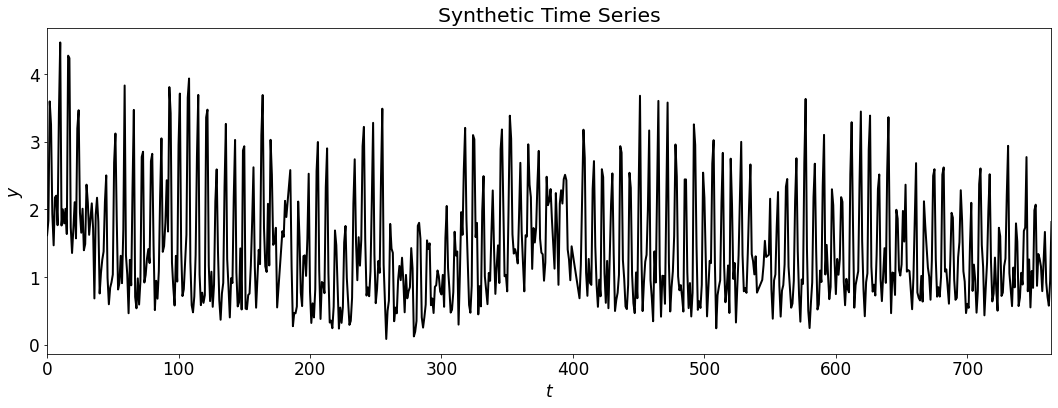

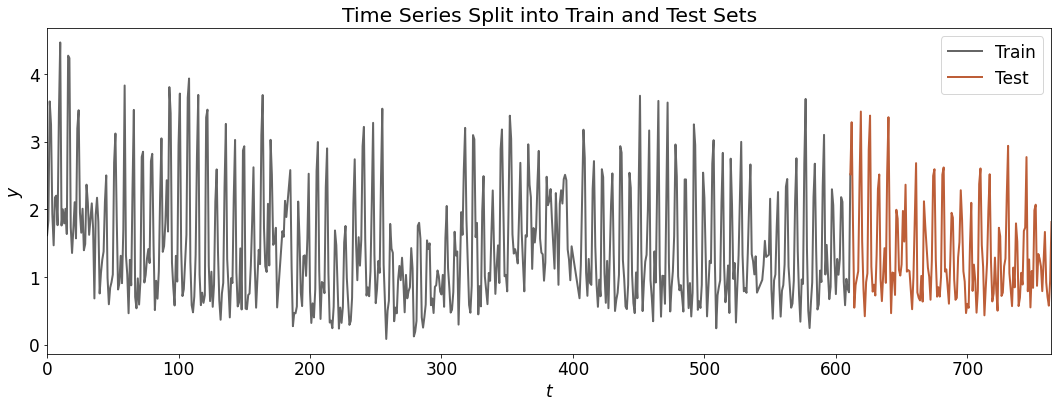

In [ ]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import sys

# import generate_dataset
# import lstm_encoder_decoder
# import plotting 

matplotlib.rcParams.update({'font.size': 17})

#----------------------------------------------------------------------------------------------------------------
# generate dataset for LSTM
# t, y = synthetic_data()
t , y = get_data()
t_train, y_train, t_test, y_test = train_test_split(t, y, split = 0.8)

# plot time series 
plt.figure(figsize = (18, 6))
plt.plot(t, y, color = 'k', linewidth = 2)
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title('Synthetic Time Series')
plt.savefig('./synthetic_time_series.png')

# plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(t_train, y_train, color = '0.4', linewidth = 2, label = 'Train') 
plt.plot(np.concatenate([[t_train[-1]], t_test]), np.concatenate([[y_train[-1]], y_test]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([t[0], t[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
plt.savefig('./train_test_split.png')


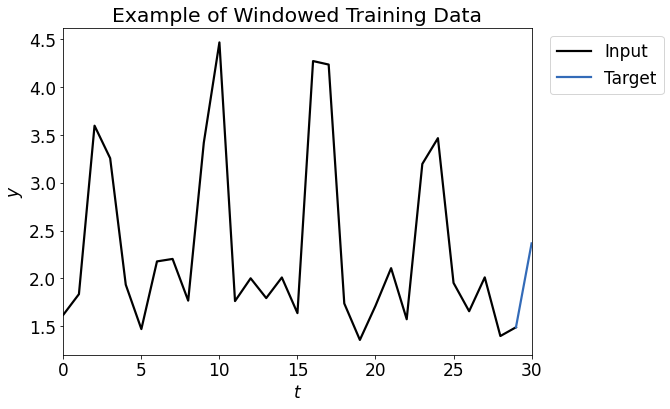

In [ ]:

#----------------------------------------------------------------------------------------------------------------
# window dataset

# set size of input/output windows 
iw = 30 
ow = 1 
s = 1

# generate windowed training/test datasets
Xtrain, Ytrain= windowed_dataset(y_train, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = windowed_dataset(y_test, input_window = iw, output_window = ow, stride = s)

# plot example of windowed data  
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 
plt.savefig('./windowed_data.png')


In [ ]:
Ytrain.shape

(1, 582, 1)

In [ ]:

#----------------------------------------------------------------------------------------------------------------
# LSTM encoder-decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model = lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 128)
loss = model.train_model(X_train, Y_train, n_epochs = 1000, target_len = ow, batch_size = 8  , 
                  training_prediction = 'teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.05, dynamic_tf = True)


cpu


100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s, loss=0.07526]


In [ ]:

# plot predictions on train/test data
plot_train_test_results(model, Xtrain, Ytrain, Xtest, Ytest)

plt.close('all')

In [ ]:
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(30, 582, 1) (1, 582, 1) (30, 123, 1) (1, 123, 1)


----------------Train----------------
准确度:51.47187888309587%
R2:0.4957125446992613
----------------Test----------------
准确度:51.7317062629854%
R2:0.16510726215273697


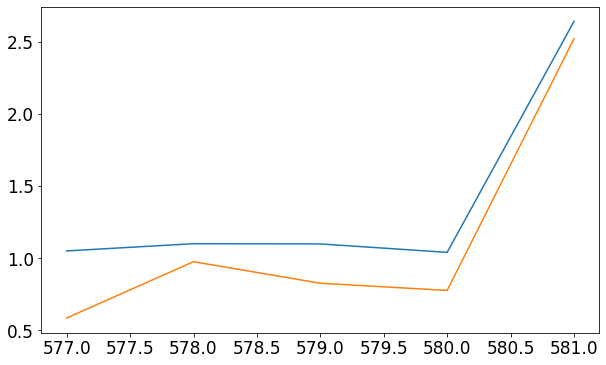

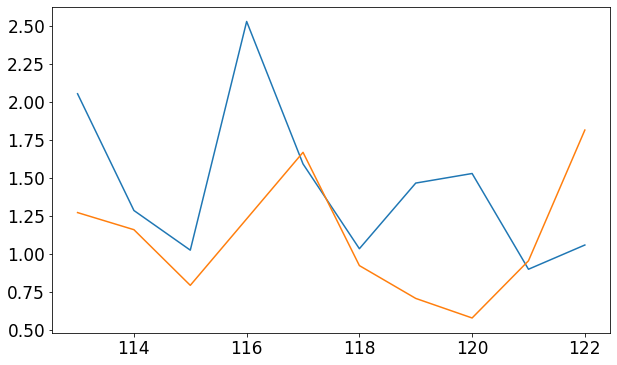

In [ ]:
metricloss(model, Xtrain, Ytrain, Xtest, Ytest,10)